<center>
<h1> SOLUCIÓN TAREA 14 - Reducción de dimensionalidad
</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

In [37]:
#Importar las librerias necesarias
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics.pairwise import (chi2_kernel, laplacian_kernel,
                                      linear_kernel, polynomial_kernel,
                                      rbf_kernel, sigmoid_kernel)
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from sklearn.decomposition import KernelPCA, PCA
from sklearn.datasets import make_moons

## 1. Implementación de aun algortimo Kernel Discriminant Analysis KDA

El algoritmo de KDA es una combinación de técnicas para la reducción de dimensionalidad en la información de nuestro trabajo, para lo cual se aplica una función de Kernel a los datos para pasarlos a un espacio de alta dimensionalidad, donde estos sean mass faciles de clasificar, para luego ser pasados por un algoritmo de LDA en este espacio para separarlos.


In [38]:
class KernelDiscriminantAnalysis(BaseEstimator, ClassifierMixin,
                                 TransformerMixin):
    """Kernel Discriminant Analysis.

    Parameters
    ----------
    lmb: float (>= 0.0), default=0.001
         Regularization parameter
    kernel: {"chi2", "laplacian", "linear", "polynomial", "rbf", "sigmoid"},
            default='rbf'
            Kernel.
    degree: integer, default=3
    gamma: float, default=None
    coef0: integer, default=1

    """

    def __init__(self, lmb=0.001, kernel='rbf', degree=3, gamma=None, coef0=1):
        self.lmb = lmb
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0

    def _kernel(self, X, Y=None):
        """Kernel"""
        kernel = None
        if self.kernel == 'chi2':
            kernel = chi2_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'laplacian':
            kernel = laplacian_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'linear':
            kernel = linear_kernel(X, Y)
        elif self.kernel == 'polynomial':
            kernel = polynomial_kernel(X, Y, degree=self.degree,
                                       gamma=self.gamma, coef0=self.coef0)
        elif self.kernel == 'rbf':
            kernel = rbf_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'sigmoid':
            kernel = sigmoid_kernel(X, Y, gamma=self.gamma, coef0=self.coef0)
        return kernel

    def fit(self, X, y):
        """Fit KDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           Training set.
        y: numpy array of shape [n_samples]
           Target values. Only works for 2 classes.

        Returns
        -------
        self

        """
        n = len(X)
        self._X = X
        self._H = np.identity(n) - 1 / n * np.ones(n) @ np.ones(n).T
        self._E = OneHotEncoder().fit_transform(y.reshape(n, 1))
        _, counts = np.unique(y, return_counts=True)
        K = self._kernel(X)
        C = self._H @ K @ self._H
        self._Delta = np.linalg.inv(C + self.lmb * np.identity(n))
        A = self._E.T @ C
        B = self._Delta @ self._E
        self._Pi_12 = np.diag(np.sqrt(1.0 / counts))
        P = self._Pi_12 @ A
        Q = B @ self._Pi_12
        R = P @ Q
        V, Gamma, self._U = np.linalg.svd(R, full_matrices=False)
        return self

    def transform(self, X):
        """Transform data with the trained KFDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           The input data.

        Returns
        -------
        y_pred: array-like, shape (n_samples, targets_shape)
                Transformations for X.

        """
        _K = self._kernel(X, self._X)
        K = _K - np.mean(_K, axis=0)
        C = self._H @ K.T
        T = self._U @ self._Pi_12 @ self._E.T @ self._Delta
        Z = T @ C
        return Z.T

## 2. Evaluar los algoritmos PCA, LDA, KPCA y KDA, en la reducción de la dimensión.


Aqui nuevamente utilizaremos el dataset de iris para probar estos algoritmos de reducción de dimensionalidad.

In [39]:
# Cargamos el dataset de iris
df = pd.read_csv('iris.csv')
df.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [40]:
Variables = df.columns[:-1]
Variables

Index(['sepallength', 'sepalwidth', 'petallength', 'petalwidth'], dtype='object')

In [41]:
# Separando los variables que nos aportan información del dataset
X = df[Variables].copy()
# Separamos las clases presentes en nuestro data set
y = df['class'].values.reshape(-1)

In [42]:
# Estandarización de los datos
Escalado = StandardScaler()
Escalado = Escalado.fit_transform(X)
df_standard = pd.DataFrame(Escalado,columns=[Variables])
df_standard.head()

,sepallength,sepalwidth,petallength,petalwidth
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


### PCA

In [43]:
#Implementando y aplicando el algoritmo PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Escalado)

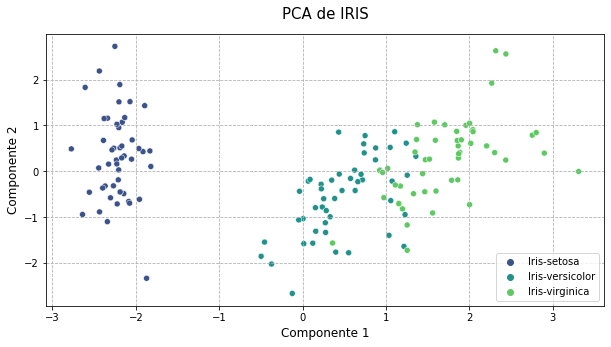

In [44]:
fig, ax = plt.subplots(figsize = (10,5))
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue=y, palette='viridis')
ax.set_title("PCA de IRIS", fontsize=15, pad=15)
ax.set_xlabel("Componente 1", fontsize=12)
ax.set_ylabel("Componente 2", fontsize=12)
ax.grid(linestyle='--')
plt.show()

### LDA

In [45]:
#Implementando y aplicando el algoritmo LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(Escalado, y)

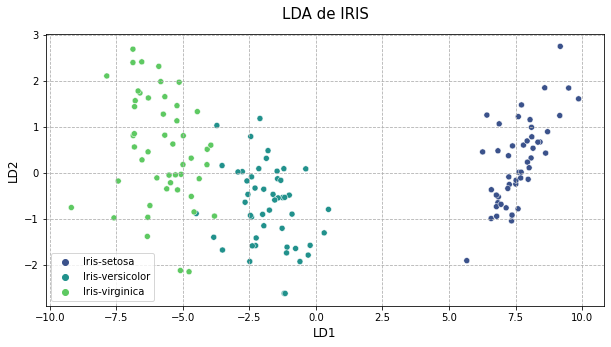

In [46]:
fig, ax = plt.subplots(figsize = (10,5))
sns.scatterplot(x = X_lda[:,0], y = X_lda[:,1], hue=y, palette='viridis')
ax.set_title("LDA de IRIS", fontsize=15, pad=15)
ax.set_xlabel("LD1", fontsize=12)
ax.set_ylabel("LD2", fontsize=12)
ax.grid(linestyle='--')
plt.show()

### Kernel - PCA

Los métodos de Kernel son especializados en la transformación de datos con una clasificación no lineal, en un espacio de de alta dimensionalidad donde sea linealmente separables. Para demostrar su capacidad de separación de datos no lineales ademas de usar el dataset Iris.

In [47]:
#Implementando y aplicando el algoritmo KPCA usando 2 kernels en el dataset Iris
kpca1 = KernelPCA(n_components=2, kernel='rbf')
kpca2 = KernelPCA(n_components=2, kernel='poly')
X_kpca1 = kpca1.fit_transform(Escalado)
X_kpca2 = kpca2.fit_transform(Escalado)

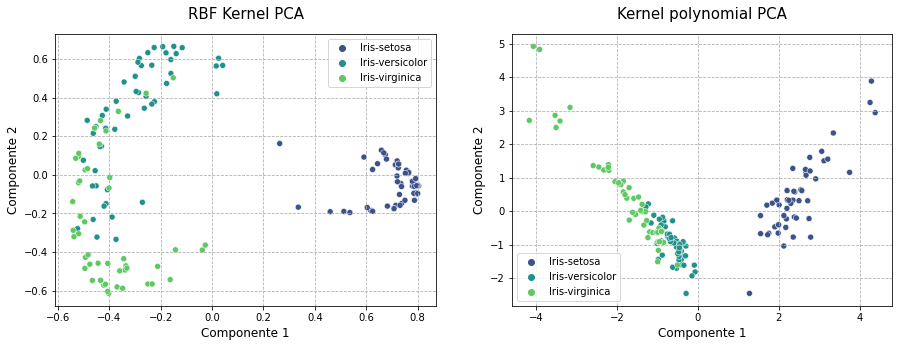

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15 ,5))
sns.scatterplot(x = X_kpca1[:, 0], y = X_kpca1[:, 1], hue=y, palette='viridis', ax=ax[0])
sns.scatterplot(x = X_kpca2[:, 0], y = X_kpca2[:, 1], hue=y, palette='viridis', ax=ax[1])
ax[0].set_title("RBF Kernel PCA", fontsize=15, pad=15)
ax[1].set_title("Kernel polynomial PCA", fontsize=15, pad=15)
ax[0].set_xlabel("Componente 1", fontsize=12)
ax[0].set_ylabel("Componente 2", fontsize=12)
ax[1].set_xlabel("Componente 1", fontsize=12)
ax[1].set_ylabel("Componente 2", fontsize=12)
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
plt.show()

### KDA

In [49]:
#Implementando y aplicando el algoritmo KDA 
kda = KernelDiscriminantAnalysis(kernel='rbf', gamma = 4)
kda = kda.fit(Escalado, y)
X_kda = kda.transform(Escalado)

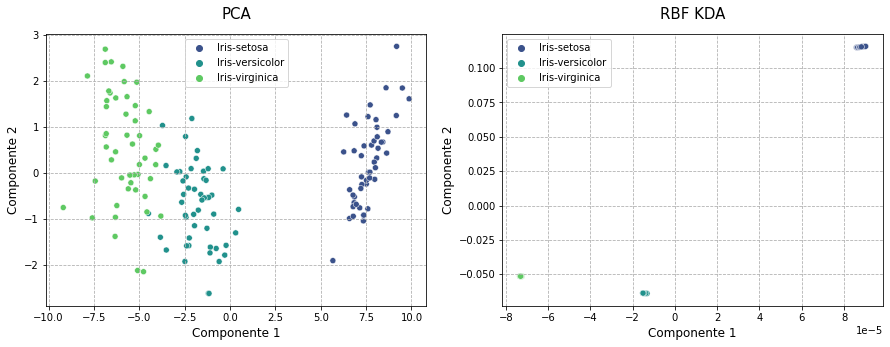

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15 ,5))
sns.scatterplot(x = X_lda[:, 0], y = X_lda[:, 1], hue=y, palette='viridis', ax=ax[0])
sns.scatterplot(x = X_kda[:, 0], y = X_kda[:, 1], hue=y, palette='viridis', ax=ax[1])
ax[0].set_title("PCA", fontsize=15, pad=15)
ax[1].set_title("RBF KDA", fontsize=15, pad=15)
ax[0].set_xlabel("Componente 1", fontsize=12)
ax[0].set_ylabel("Componente 2", fontsize=12)
ax[1].set_xlabel("Componente 1", fontsize=12)
ax[1].set_ylabel("Componente 2", fontsize=12)
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
plt.show()

En conclusión podemos ver como estos algoritmos de reducción de dimensionalidad reducen el espacio de tiempo y almacenamiento requerido para ejecutar un programa, adicional se hace más fácil la visualización de los datos cuando se reduce a dimensiones muy bajas tales como 2D o 3D.